In [1]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from math import factorial
import requests
from bs4 import BeautifulSoup
from IPython.display import Markdown, display,IFrame,HTML,Image
from itertools import product
from z3 import *

### Puzzle as published
https://www.janestreet.com/puzzles/arc-edge-acreage-index/

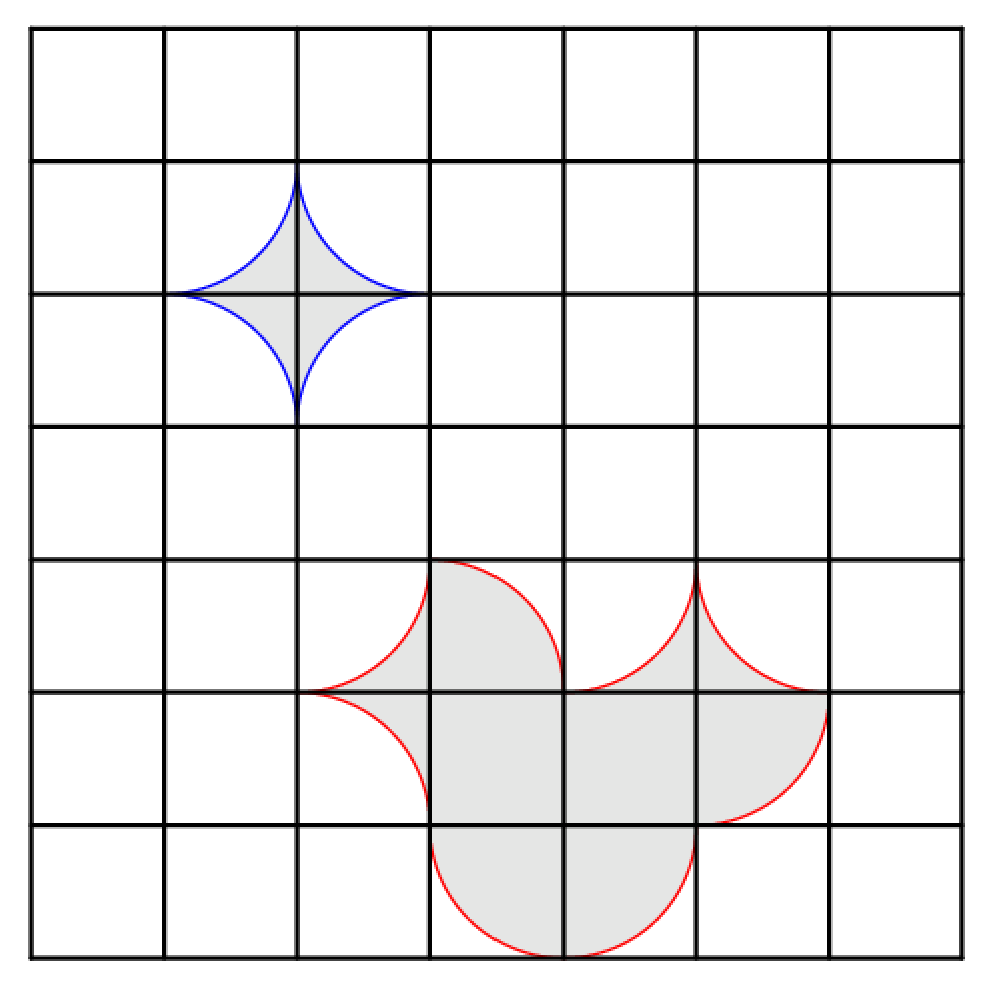

### Arc-edge Acreage

April 2023 : Puzzle
In the 7-by-7 grid above, one can draw a simple
1
closed curve using
nothing but quarter-circle segments. Two examples are shown above: one
enclosing a region of 4-π (in blue), and one enclosing a region of
area 6 (in red).
It can be shown that there are 36 ways to enclose a region of area
exactly 4-π. How many ways can one draw a curve enclosing a region of
area exactly
32
?
Note that a simple curve is not allowed to self-intersect.
↩

In [2]:
url='https://www.janestreet.com/puzzles/arc-edge-acreage-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Puzzle as published\n'+url))
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Image('https://www.janestreet.com/puzzles/arc-edge-acreage.png',width=200))
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[9:18]))))

In [3]:
def neigh(x,y,N):
    return [(i+x,j+y) for i,j in [(-1,0),(0,-1),(1,0),(0,1)] if i+x >=0 and i+x <=N and j+y >=0 and j+y <=N]

def diag(x,y,N):
    return [(i+x,j+y) for i,j in [(-1,-1),(1,-1),(-1,1),(1,1)] if i+x >=0 and i+x <=N and j+y >=0 and j+y <=N]

In [4]:
# Model as nodes rather than cells. Model curves as straight lines, then work out how many permutations there are of each shape with equal 
# small and large arcs.

s = Tactic("default").solver()
N = 8

# label nodes as 0 = outside, 1= boundary,2= inside
X = np.array(IntVector("x",N**2),dtype=object).reshape((N,N))
s += [And(e>=0,e<=2) for (i,j),e in np.ndenumerate(X)]

#Pick's theorem for area
s += Sum([e for (i,j),e in np.ndenumerate(X)])  == (32+1)*2

# Set up edges. 
edge ={}
for i,j in product(range(N),repeat=2):
    for (k,l) in diag(i,j,N-1):
        edge[(i,j,k,l)] = Int("e%d%d%d%d" % (i,j,k,l))
        s+= Or(edge[(i,j,k,l)] ==1,edge[(i,j,k,l)]==0)
        s+= Implies(edge[(i,j,k,l)] ==1,X[i,j]==1,X[k,l]==1)
            
            
#  Make 1 way and directed. Number to avoid subloops            
Y = np.array(IntVector("y",N**2),dtype=object).reshape((N,N))    
s += [And(e>=0,e<=N**2) for (i,j),e in np.ndenumerate(Y)]
s += PbEq([(e==0,1) for (i,j),e in np.ndenumerate(Y)],1)

for i,j in product(range(N),repeat=2):
    #one edge in and out of each node
    s+= Implies(X[i,j]==1,Sum([edge[(i,j,k,l)] for (k,l) in diag(i,j,N-1) ])==1)
    s+= Implies(X[i,j]==1,Sum([edge[(k,l,i,j)] for (k,l) in diag(i,j,N-1) ])==1)
    s+= Implies(X[i,j]!=1,Sum([edge[(i,j,k,l)] for (k,l) in diag(i,j,N-1) ])==0)
    for (k,l) in diag(i,j,N-1):
        #unique edges and ordered
        s+=edge[(i,j,k,l)] + edge[(k,l,i,j)] <=1
        s+=Implies(edge[(i,j,k,l)]==1, Or(Y[k,l]+1 == Y[i,j],Y[i,j]==0))
                    
#lattice edge points aren't inside
s+= [e!=2 for (i,j),e in np.ndenumerate(X) if i==0 or i==N-1 or j==0 or j==N-1] 

#determine the nodes inside
for i,j in product(range(1,N-1),repeat=2):
    for x,y in [(-1,-1),(-1,1),(1,-1),(1,1)]:
        # transition inside to out across edge
        for a in [0,2]:
            s+=Implies(And(X[i,j]==a,Or(edge[(i+x,j,i,j+y)]==1 ,edge[(i,j+y,i+x,j)]==1 )),X[i+x,j+y]!=a)
        # no change if not edge    
        for a,b in [(0,2),(2,0)]:
            s+=Implies(And(X[i,j]==a,And(edge[(i+x,j,i,j+y)]==0 ,edge[(i,j+y,i+x,j)]==0 )),X[i+x,j+y]!=b)            

# boundary nodes not adjacent
s += [Implies(Or([X[x,y]==1 for x,y in neigh(i,j,N-1)]),e !=1) for (i,j),e in np.ndenumerate(X)]

In [5]:
start = time.time()
count = 0
tot = 0
shapes = []

while s.check() == sat:
    m = s.model()
    evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
    result =  evalu(X)
    e_result = {i:evalu(e) for i,e in edge.items()}
    shapes.append(e_result)
    s+= Or([X[i,j] != int(e) for (i,j),e in np.ndenumerate(result)])
    count +=1
    # for boundary length 2n there are 2n choose n variants of the edges
    boundary_length = int(np.sum(result==1))
    tot += factorial(boundary_length)/factorial(int(boundary_length/2))**2
          
print("Answer is {:,.0f}. Found {:,.0f} shapes in {:,.2f} seconds ".format(tot,count,time.time()-start))

Answer is 89,519,144. Found 110 shapes in 583.52 seconds 


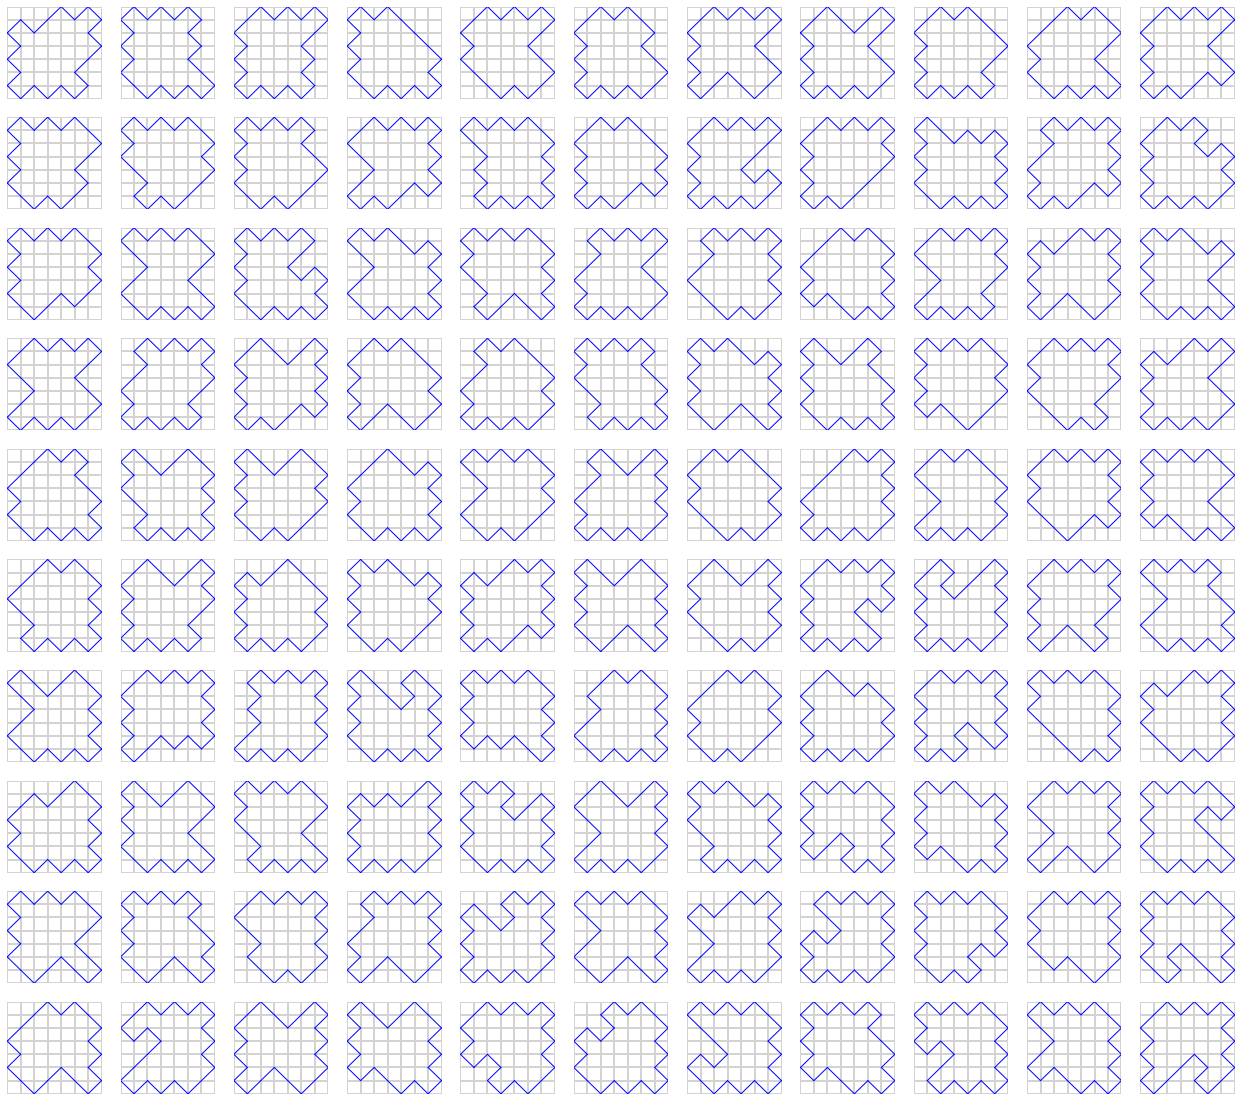

In [10]:
fig,ax = plt.subplots(10,11,figsize=(22,20))

for n,shape in enumerate(shapes):
    x,y = n//11,n%11
    sns.heatmap(np.zeros((7,7)),cbar=False,cmap="Greys",fmt="",linewidths=2,linecolor="lightgrey",ax=ax[x,y])
    for (i,j,k,l),e in shape.items():  
        if e==1:
            ax[x,y].plot([i,k],[j,l], linewidth=1,color="b")
    ax[x,y].axis("off")    

### Solution as published
https://www.janestreet.com/puzzles/arc-edge-acreage-solution/

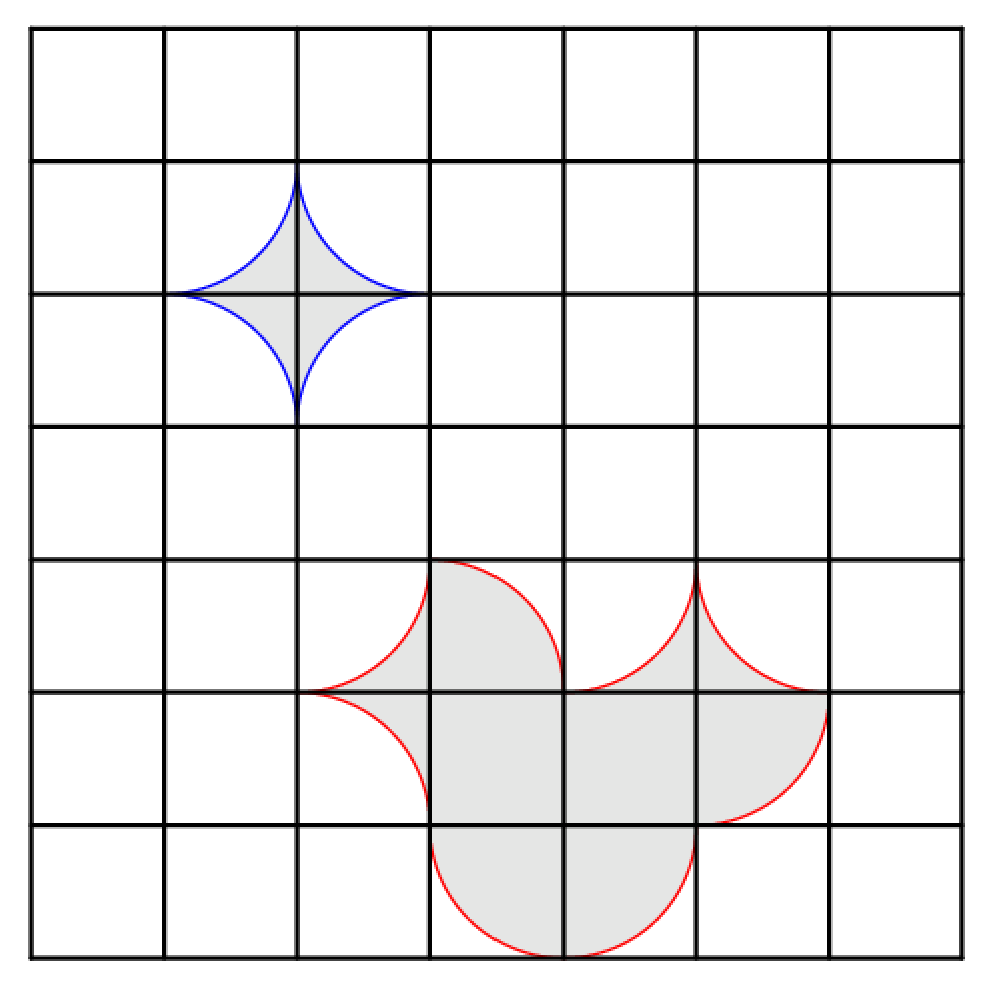

### Our Offices

Puzzles
Join Jane Street
Overview
Departments
Open Roles
Programs and Events
Interviewing
Contact Us
Disclosures & Policies

In [9]:
url='https://www.janestreet.com/puzzles/arc-edge-acreage-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Solution as published\n'+url))
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Image('https://www.janestreet.com/puzzles/arc-edge-acreage.png',width=200))
display(Markdown("### "+y[8]+"\n\n"+str("\n".join(y[9:18]))))